In [1]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

In [2]:
def sigmoid(z):
    import numpy as np
    sigm = 1/(1+np.exp(-z))
    return sigm

def loss(h, y):
    import numpy as np
    temp = np.multiply(y, np.log2(h))
    loss = -np.sum(temp, axis=1)        
    return loss

def normalize(x, interval):
    import numpy as np
    x1 = np.array(x)
    x_normalized =  interval[0] + (x1 - min(x))*(interval[1] - interval[0])/(max(x) - min(x))
    return x_normalized

def add_ones_left(df):
    left_ones = np.ones(df.shape[0])
    df['ones'] = left_ones

    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]    
    return df

def softmax(df):
    out = df.copy()
    for i in range(df.shape[0]):
        temp = 0
        for j in range(df.shape[1]):
            temp = temp + math.exp(df[i,j])
        for j in range(df.shape[1]):
            out[i,j] = math.exp(df[i,j])/temp
    return out

### Read data

In [5]:
X_train = pd.read_csv('har_smartphone/X_train.txt', delimiter = '\s+', header = None)
X_test = pd.read_csv('har_smartphone/X_test.txt', delimiter = '\s+', header = None)
y_train_data = pd.read_csv('har_smartphone/y_train.txt', delimiter = '\s+', header = None)
y_test_data = pd.read_csv('har_smartphone/y_test.txt', delimiter = '\s+', header = None)

X_train = add_ones_left(X_train)
X_test  = add_ones_left(X_test)

### One-hot encoding

In [6]:
N_CLASSES = 6
y_train = np.zeros([y_train_data.shape[0], N_CLASSES])
for idx, v in enumerate(y_train_data[0]):
    y_train[idx, v-1] = 1

y_test = np.zeros([y_test_data.shape[0], N_CLASSES])
for idx, v in enumerate(y_test_data[0]):
    y_test[idx, v-1] = 1

### Check data balance

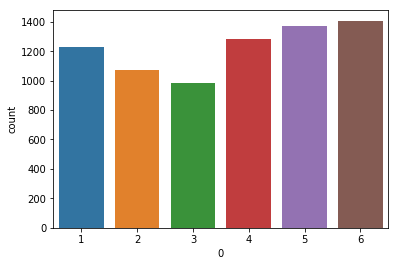

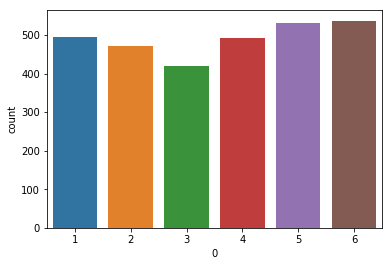

In [8]:
sns.countplot(x=0, data=y_train_data)
plt.show()

sns.countplot(x=0, data=y_test_data)
plt.show()

### Model and training

Iteration: 1000 -- Training Loss: 0.20151369050888482 -- Validation Loss: 0.23431861142560512
Amount of iterations after the current minimum loss function on the validation set: 1
Iteration: 2000 -- Training Loss: 0.11525786200005243 -- Validation Loss: 0.14843896114998176
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 3000 -- Training Loss: 0.09808234843341385 -- Validation Loss: 0.13208828623214836
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 4000 -- Training Loss: 0.08742076859794487 -- Validation Loss: 0.12173804606828068
Amount of iterations after the current minimum loss function on the validation set: 0
Iteration: 5000 -- Training Loss: 0.07994378523137508 -- Validation Loss: 0.11450693064297317
Amount of iterations after the current minimum loss function on the validation set: 0


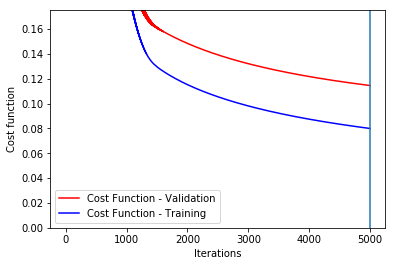

In [9]:
# Inicialize weights
VAL_PROPORTION = 0.2
theta = np.zeros((X_train.shape[1], N_CLASSES))

ls_training = []
ls_val = []

# Learning rate
lr = 0.1

# Threshold
threshold = 0.5

# Number of iterations
iterations = 5000

#Number of additional iterations after a minimum on validation set
MAX_IT_AFTER_MIN = 10000
it_after_min = 0
min_cost_val = 2**10 #high number

# Training loop
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=VAL_PROPORTION, random_state=42)


for i in range(iterations):    
    it_after_min = it_after_min + 1    
    # Input x Weights
    
    z = np.dot(X_training, theta)    
    # Sigmoid
    h_training = softmax(z)
    # Gradient descent
    gradient = np.dot(X_training.transpose() , h_training - y_training)/y_training.shape[0]
    #print(gradient)
    theta = theta - lr * gradient
    
    h_training = softmax(np.dot(X_training, theta))
    cross_entropy = loss(h_training, y_training).mean()
    ls_training.append(cross_entropy)

    h_val = softmax(np.dot(X_val, theta))
    ls_val.append(loss(h_val, y_val).mean())
    
    if ls_val[-1] < min_cost_val:
        it_after_min = 0
        opt_theta = theta
        min_cost_val = ls_val[-1]
        best_it_idx = i
        
    if it_after_min == MAX_IT_AFTER_MIN:
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i, ls_training[-1], ls_val[-1]))
        break        
    
    # Print info
    if((i+1)%1000 == 0):        
        print('Iteration: {} -- Training Loss: {} -- Validation Loss: {}'. format(i+1, ls_training[-1], ls_val[-1]))
        print('Amount of iterations after the current minimum loss function on the validation set: {}'.format(it_after_min))
theta = opt_theta
        
    
# Plot loss
plt.plot(ls_val, color = 'red', label="Cost Function - Validation")
plt.plot(ls_training, color = 'blue', label ="Cost Function - Training")
plt.axvline(x=best_it_idx)
plt.ylim(0, 0.175)
plt.xlabel('Iterations')
plt.ylabel('Cost function')
plt.legend()
plt.show()    

### Predict and get metrics

In [1]:
prob = softmax(np.dot(X_test, theta))
y_pred = np.argmax(prob, axis = 1) + 1

# Accuracy
print('Accuracy: {}'.format(np.equal(y_pred ,y_test_data[0]).mean()))

# F1 Score
print('F1 Score: {}'.format(f1_score(y_test_data[0], y_pred, average='weighted')))

NameError: name 'softmax' is not defined

### Confusion matrix

In [4]:
normalize = False
cm = confusion_matrix(y_test_data[0], y_pred)
cmap = plt.cm.Blues
classes = ['1', '2', '3', '4', '5', '6']

for normalize in [False, True]:

    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

NameError: name 'confusion_matrix' is not defined